In [ ]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:09<00:00, 186MB/s]
100% 1.33G/1.33G [00:09<00:00, 143MB/s]


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [4]:
%cd /content/drive/MyDrive/kaggle/

/content/drive/MyDrive/kaggle


In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:08<00:00, 205MB/s]
100% 1.33G/1.33G [00:08<00:00, 174MB/s]


In [8]:
!kaggle datasets download -d jessicali9530/celeba-dataset --unzip

100% 1.33G/1.33G [00:07<00:00, 266MB/s]
100% 1.33G/1.33G [00:07<00:00, 197MB/s]
User cancelled operation


In [1]:
import numpy as np
import pandas as pd
import os

PIC_DIR = f'/content/drive/MyDrive/kaggle/img_align_celeba/img_align_celeba/'
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
  pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
  pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
  images.append(np.uint8(pic))


100%|██████████| 10000/10000 [01:30<00:00, 110.46it/s]


In [2]:
images = np.array(images) / 255
print(images.shape)


from matplotlib import pyplot as plt


(10000, 128, 128, 3)


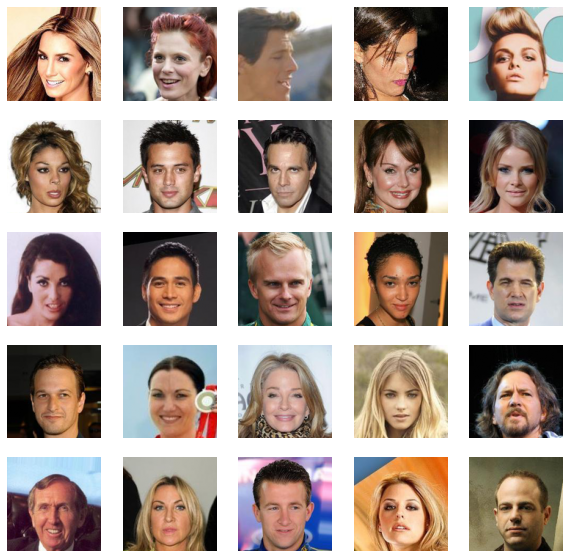

In [5]:

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()
     

In [6]:

from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3


In [7]:
# Function to create the generator model
def create_generator():
    # Input layer with latent dimension shape
    gen_input = Input(shape=(LATENT_DIM, ))

    # First dense layer with 128 * 16 * 16 neurons
    x = Dense(128 * 16 * 16)(gen_input)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)
    # Reshape the output to 16x16x128
    x = Reshape((16, 16, 128))(x)

    # First Conv2D layer with 256 filters and 5x5 kernel size, padding set to 'same'
    x = Conv2D(256, 5, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)

    # First Conv2DTranspose layer with 256 filters, 4x4 kernel size, 2 strides and padding set to 'same'
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)

    # Second Conv2DTranspose layer with 256 filters, 4x4 kernel size, 2 strides and padding set to 'same'
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)

    # Third Conv2DTranspose layer with 256 filters, 4x4 kernel size, 2 strides and padding set to 'same'
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)

    # Fourth Conv2D layer with 512 filters and 5x5 kernel size, padding set to 'same'
    x = Conv2D(512, 5, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)
    # Fifth Conv2D layer with 512 filters and 5x5 kernel size, padding set to 'same'
    x = Conv2D(512, 5, padding='same')(x)
    # Apply leaky relu activation function
    x = LeakyReLU()(x)
    # Final Conv2D layer with CHANNELS filters and 7x7 kernel size, activation set to 'tanh', padding set to 'same'
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    # Create the generator model
    generator = Model(gen_input, x)
    # Return the generator model
    return generator

# Defining the Discriminator Model
def create_discriminator():
    # Input layer for the discriminator with the shape of (HEIGHT, WIDTH, CHANNELS)
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    # First Conv2D layer with 256 filters of size 3x3
    x = Conv2D(256, 3)(disc_input)
    # Applying LeakyReLU activation function
    x = LeakyReLU()(x)

    # Second Conv2D layer with 256 filters of size 4x4 and stride of 2
    x = Conv2D(256, 4, strides=2)(x)
    # Applying LeakyReLU activation function
    x = LeakyReLU()(x)

    # Third Conv2D layer with 256 filters of size 4x4 and stride of 2
    x = Conv2D(256, 4, strides=2)(x)
    # Applying LeakyReLU activation function
    x = LeakyReLU()(x)

    # Fourth Conv2D layer with 256 filters of size 4x4 and stride of 2
    x = Conv2D(256, 4, strides=2)(x)
    # Applying LeakyReLU activation function
    x = LeakyReLU()(x)

    # Fifth Conv2D layer with 256 filters of size 4x4 and stride of 2
    x = Conv2D(256, 4, strides=2)(x)
    # Applying LeakyReLU activation function
    x = LeakyReLU()(x)

    # Flattening the output from the Conv2D layers
    x = Flatten()(x)
    # Adding a Dropout layer with rate of 0.4
    x = Dropout(0.4)(x)

    # Adding a dense layer with 1 output and sigmoid activation function
    x = Dense(1, activation='sigmoid')(x)
    # Defining the discriminator model with input and output
    discriminator = Model(disc_input, x)

    # Defining the optimizer as RMSprop with learning rate of 0.0001, clipvalue of 1.0 and decay of 1e-8
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    # Compiling the discriminator model with optimizer and loss function as binary cross-entropy
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    # Returning the compiled discriminator model
    return discriminator

# Calling the create_generator() function to get the generator model
generator = create_generator()
# Calling the create_discriminator() function to get the discriminator model
discriminator = create_discriminator()
# Making the discriminator not trainable
discriminator.trainable = False


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
# Define the input layer of the GAN model with shape (LATENT_DIM, )
gan_input = Input(shape=(LATENT_DIM, ))

# Pass the gan_input through the generator model and get its output
# and then pass the generated output through the discriminator model to get the final gan_output
gan_output = discriminator(generator(gan_input))

# Create the GAN model using the gan_input as input and gan_output as output
gan = Model(gan_input, gan_output)

# Define the optimizer for the GAN model, using RMSprop with a learning rate of .0001, clipvalue of 1.0 and decay of 1e-8
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)

# Compile the GAN model with the defined optimizer and binary_crossentropy loss function
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


In [ ]:

# Import time library
import time

# Number of iterations to train the GAN model
iters = 15000
# Batch size for training
batch_size = 16

# Result directory name
RES_DIR = 'res2'
# File path for saving the generated images
FILE_PATH = '%s/generated_%d.png'

# Create the result directory if it doesn't already exist
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

# Number of control images to generate and display
CONTROL_SIZE_SQRT = 6
# Generate random control vectors with shape (CONTROL_SIZE_SQRT**2, LATENT_DIM) 
# divided by 2 to have values in the range (-0.5, 0.5)
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

# Start index for batch images from the complete dataset
start = 0
# List to store the discriminator loss values
d_losses = []
# List to store the generator (adversarial) loss values
a_losses = []
# Counter for saved images
images_saved = 0

# Loop through the number of iterations
for step in range(iters):
    # Start timer
    start_time = time.time()

    # Generate random latent vectors with shape (batch_size, LATENT_DIM)
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    # Predict the generated images from the generator model using the latent vectors
    generated = generator.predict(latent_vectors)

    # Get the real images from the complete dataset with a batch size of batch_size
    real = images[start:start + batch_size]
    # Combine the generated and real images
    combined_images = np.concatenate([generated, real])

    # Create labels for the combined images, with ones for real images and zeros for generated images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    # Add a small random value in the range (-0.05, 0.05) to the labels to make them slightly misaligned 
    labels += .05 * np.random.random(labels.shape)

    # Train the discriminator model on the combined images and their labels
    d_loss = discriminator.train_on_batch(combined_images, labels)
    # Add the discriminator loss to the list of d_losses
    d_losses.append(d_loss)

    # Generate random latent vectors with shape (batch_size, LATENT_DIM)
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    # Create misleading targets with all zeros, since the goal of the generator is to fool the discriminator
    misleading_targets = np.zeros((batch_size, 1))

    # Train the GAN model on the latent vectors and the misleading targets
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    # Store the adversarial loss for each iteration
    a_losses.append(a_loss)
    # Increment the start position for the next batch of real images
    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0
    # Save the weights of the GAN model and print progress every 50 iterations
    if step % 50 == 49:
        gan.save_weights('./drive/My Drive/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('drive/My Drive/visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)


1/1 [==============================] - 0s 18ms/step
50/15000: d_loss: 0.7097,  a_loss: 0.7146.  (2.7 sec)
1/1 [==============================] - 0s 17ms/step
100/15000: d_loss: 0.6852,  a_loss: 0.7076.  (3.7 sec)
1/1 [==============================] - 0s 20ms/step
150/15000: d_loss: 0.6403,  a_loss: 0.8694.  (2.6 sec)
1/1 [==============================] - 0s 24ms/step
200/15000: d_loss: 0.6655,  a_loss: 0.9075.  (2.6 sec)
1/1 [==============================] - 0s 25ms/step
250/15000: d_loss: 0.6407,  a_loss: 1.1297.  (2.4 sec)
1/1 [==============================] - 0s 17ms/step
300/15000: d_loss: 0.6639,  a_loss: 0.8774.  (2.4 sec)
1/1 [==============================] - 0s 17ms/step
350/15000: d_loss: 0.6430,  a_loss: 0.8674.  (3.9 sec)
1/1 [==============================] - 0s 17ms/step
400/15000: d_loss: 0.7071,  a_loss: 1.0982.  (2.6 sec)
1/1 [==============================] - 0s 19ms/step
450/15000: d_loss: 0.6959,  a_loss: 1.0139.  (2.6 sec)
1/1 [==============================] -